In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 10)

sys.path.extend([os.getcwd() + "/../", os.getcwd() + "/../../tests/python/", os.getcwd() + "/../../bin/"])
import state_space_model as ssm
#from benchmark_performance import *
import plot_utils

import numpy

In [2]:
dataset_currency = pd.read_csv('daily_csv.csv', sep=',', header=0)
dataset_currency

,Date,Country,Value
0,1971-01-04,Australia,0.8987
1,1971-01-05,Australia,0.8983
2,1971-01-06,Australia,0.8977
3,1971-01-07,Australia,0.8978
4,1971-01-08,Australia,0.8990
5,1971-01-11,Australia,0.8967
6,1971-01-12,Australia,0.8964
7,1971-01-13,Australia,0.8957
8,1971-01-14,Australia,0.8937
9,1971-01-15,Australia,0.8943


In [3]:
#countries = ["United Kingdom", "Venezuela", "India", "Brazil", "Euro", "Norway"]
countries = ["United Kingdom", "India", "Brazil", "Euro", "Norway"]
dates = dataset_currency["Date"].unique()
data_countries = {}
dates_countries = {}
for country in countries:
    country_data = dataset_currency[dataset_currency["Country"] == country]
    #country_data = country_data[country_data["Date"] in valid_dates]
    data_countries[country] = country_data
    dates_countries[country] = country_data["Date"].unique()
    print(country, country_data.shape)

valid_dates = np.array([
    date for date in dates
    if all(
        date in dates_countries[country]
        for country in countries
    )
])
print(valid_dates)

United Kingdom (12240, 3)
India (11719, 3)
Brazil (5980, 3)
Euro (4935, 3)
Norway (12240, 3)
['1999-01-04' '1999-01-05' '1999-01-06' ... '2017-11-29' '2017-11-30'
 '2017-12-01']


In [4]:
country_dates = None
country_rates = np.zeros((len(countries), len(valid_dates)), dtype="f")
for k, country in enumerate(countries):
    country_data = dataset_currency[dataset_currency["Country"] == country]
    country_data = country_data[country_data["Date"].isin(valid_dates)]
    country_dates = np.array(country_data.loc[:, "Date"], dtype=str)
    df = np.array(country_data.loc[:, "Value"]).astype("f")
    # Replace NaNs
    for _ in range(10):
        indices = np.where(np.isnan(df[:]))[0]
        if len(indices) == 0:
            print("No NaN!")
            break
        if len(indices) == 2 and indices[1] == indices[0] + 1:
            df[indices[0]] = df[indices[0] - 1] + (df[indices[1] + 2] - df[indices[0] - 1]) / 3
            df[indices[1]] = df[indices[0] - 1] + 2 * (df[indices[1] + 2] - df[indices[0] - 1]) / 3
        else:
            df[indices] = 0.5 * (df[indices + 1] + df[indices - 1])
    
    #
    country_rates[k, :] = df
    data_countries[country] = df
    print(country, data_countries[country].shape)

No NaN!
United Kingdom (4935,)
No NaN!
India (4935,)
No NaN!
Brazil (4935,)
No NaN!
Euro (4935,)
No NaN!
Norway (4935,)


(5, 4935)


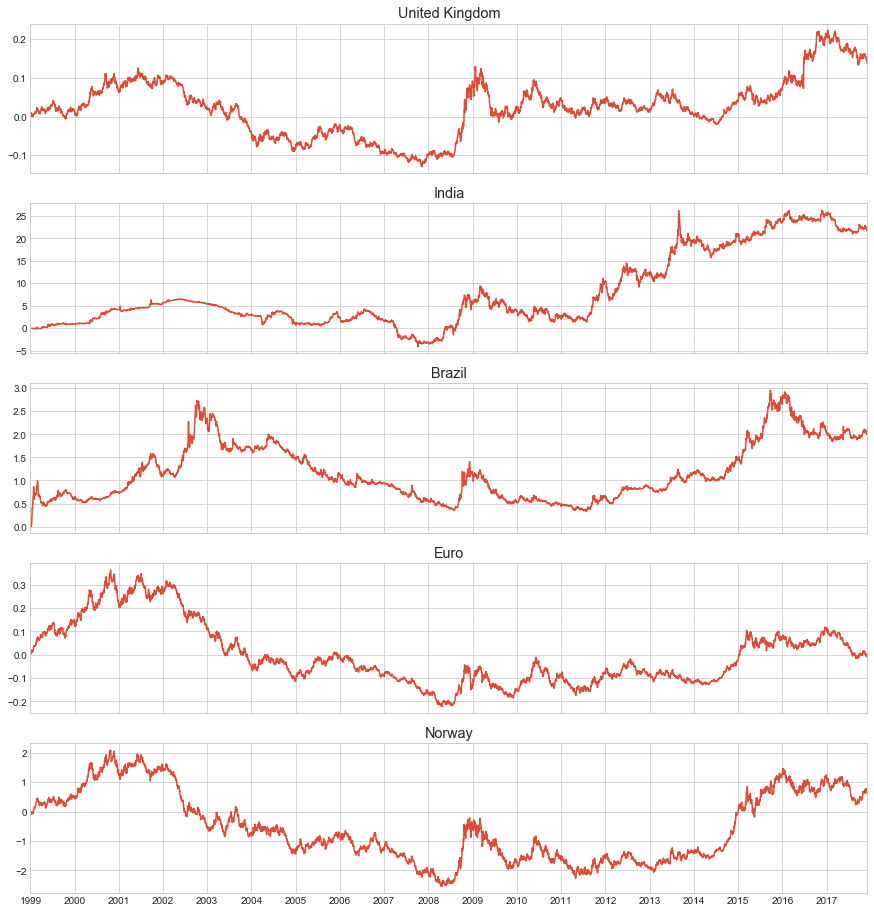

In [5]:
Yx1 = country_rates
Yx1 = (Yx1.T - Yx1[:, 0]).T
print(Yx1.shape)
#
idxnames = []
names = []
for i in np.arange(len(valid_dates)):
    name = "-".join(valid_dates[i].split("-")[:1])
    if name not in names:
        names.append(name)
        idxnames.append(i)
empty_names = [""] * len(names)
#
plt.figure(figsize=(15, 16))
for k, country in enumerate(countries):
    plt.subplot(len(countries), 1, k + 1)
    plt.plot(Yx1[k, :].ravel())
    plt.title(country)
    plt.xticks(idxnames, empty_names)
    plt.xlim(0, len(valid_dates))
plt.xticks(idxnames, names)
None

In [7]:
def plot_fitted_data(countries, Xs, Ys, Y=None, dates=None):
    nrows = max(Xs.shape[0], Ys.shape[0])
    plt.figure(figsize=(15, 5 * nrows))
    for k in range(Xs.shape[0]):
        plt.subplot(nrows, 2, 2 * k + 2)
        plt.plot(Xs[k, :].ravel(), linestyle="-.", color="black", alpha=0.5, label="Exchange rate interaction")
        plt.title("Exchange rate interaction (dim. {0})".format(k + 1))
        if dates is not None:
            plt.xticks(*dates)
        plt.xlim(0, Xs.shape[1])
        plt.legend()
    for k in range(Ys.shape[0]):
        plt.subplot(nrows, 2, 2 * k + 1)
        plt.plot(Ys[k, :].ravel(), linestyle="-", color="coral", label="Estimated exchange rate")
        plt.plot(Y[k, :].ravel(), linestyle="-.", color="black", alpha=0.5, label="Normalized exchange rate")
        plt.title("Normalized currency exchange rate - {0}".format(countries[k]))
        if dates is not None:
            plt.xticks(*dates)
        plt.xlim(0, Ys.shape[1])
        plt.legend()
    plt.tight_layout()
    plt.show()

def ticks_from_first_week_day(valid_dates):
    # Very inefficient, but it was made in 3 minutes. Do not ask me sth excellent XD
    idxnames = []
    names = []
    vnames = []
    for i in np.arange(len(valid_dates)):
        parts = valid_dates[i].split("-")
        month = int(parts[1])
        day = int(parts[2])
        if len(vnames) == 0 and day > 20:
            month += 1
            day = 1
        day = min(1, day // 15)
        vname = "{0}-{1}".format(month, day)
        parts = parts[1:]
        name = "/".join(parts)
        if vname not in vnames:
            vnames.append(vname)
            names.append(name)
            idxnames.append(i)
    #empty_names = [""] * len(names)
    return idxnames, names
#print(Y_dates)

In [8]:

class resdict:
    Xp = None
    Pp = None
    Yp = None
    Xf = None
    Pf = None
    Yf = None
    Xs = None
    Ps = None
    Ys = None
    LL = None
    F = None
    H = None
    Q = None
    H = None
    X0 = None
    P0 = None
    obs_dim = None
    lat_dim = None
    
    def show_performance(self, Y):
        performance = lambda params, Y, lat_dim: print("\n".join("* {0}: {1:.2g}".format(b, np.round(a, 2)) for a, b in zip(ssm.performance_of_parameters(Y, Y.shape[0], lat_dim, Y.shape[1], params.F, params.H, params.Q, params.R, params.X0, params.P0), ("Log-likelihood", "Low variance Q", "Low variance R", "Low variance P0", "Low std/mean ratio", "Inestable system", "MSE", "Roughness X", "Roughness Y"))))
        return performance(self, Y, self.lat_dim)


def resdict_fromdata(V):
    obj = resdict()
    obj.F = V[0]
    obj.H = V[1]
    obj.Q = V[2]
    obj.R = V[3]
    obj.X0 = V[4]
    obj.P0 = V[5]
    obj.obs_dim = obj.H.shape[0]
    obj.lat_dim = obj.P0.shape[0]
    #
    obj.Xp = V[6]
    obj.Pp = V[7]
    obj.Yp = V[8]
    obj.Xf = V[9]
    obj.Pf = V[10]
    obj.Yf = V[11]
    obj.Xs = V[12]
    obj.Ps = V[13]
    obj.Ys = V[14]
    obj.LL = V[15]
    #
    return obj


In [9]:
#Y.mean(axis=1).shape, Y.shape


* Log-likelihood: 0
* Low variance Q: 10
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0.63
* MSE: 0.41
* Roughness X: 0.74
* Roughness Y: 9.5

* Log-likelihood: 0
* Low variance Q: 6.7
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0.63
* MSE: 0.4
* Roughness X: 0.73
* Roughness Y: 9.3

* Log-likelihood: 0
* Low variance Q: 2.7e+02
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 13
* MSE: 0.39
* Roughness X: 3.3
* Roughness Y: 11

* Log-likelihood: 0
* Low variance Q: 1e+02
* Low variance R: 1
* Low variance P0: 0.03
* Low std/mean ratio: 1
* Inestable system: 6.1
* MSE: 0.4
* Roughness X: 0.56
* Roughness Y: 7.2


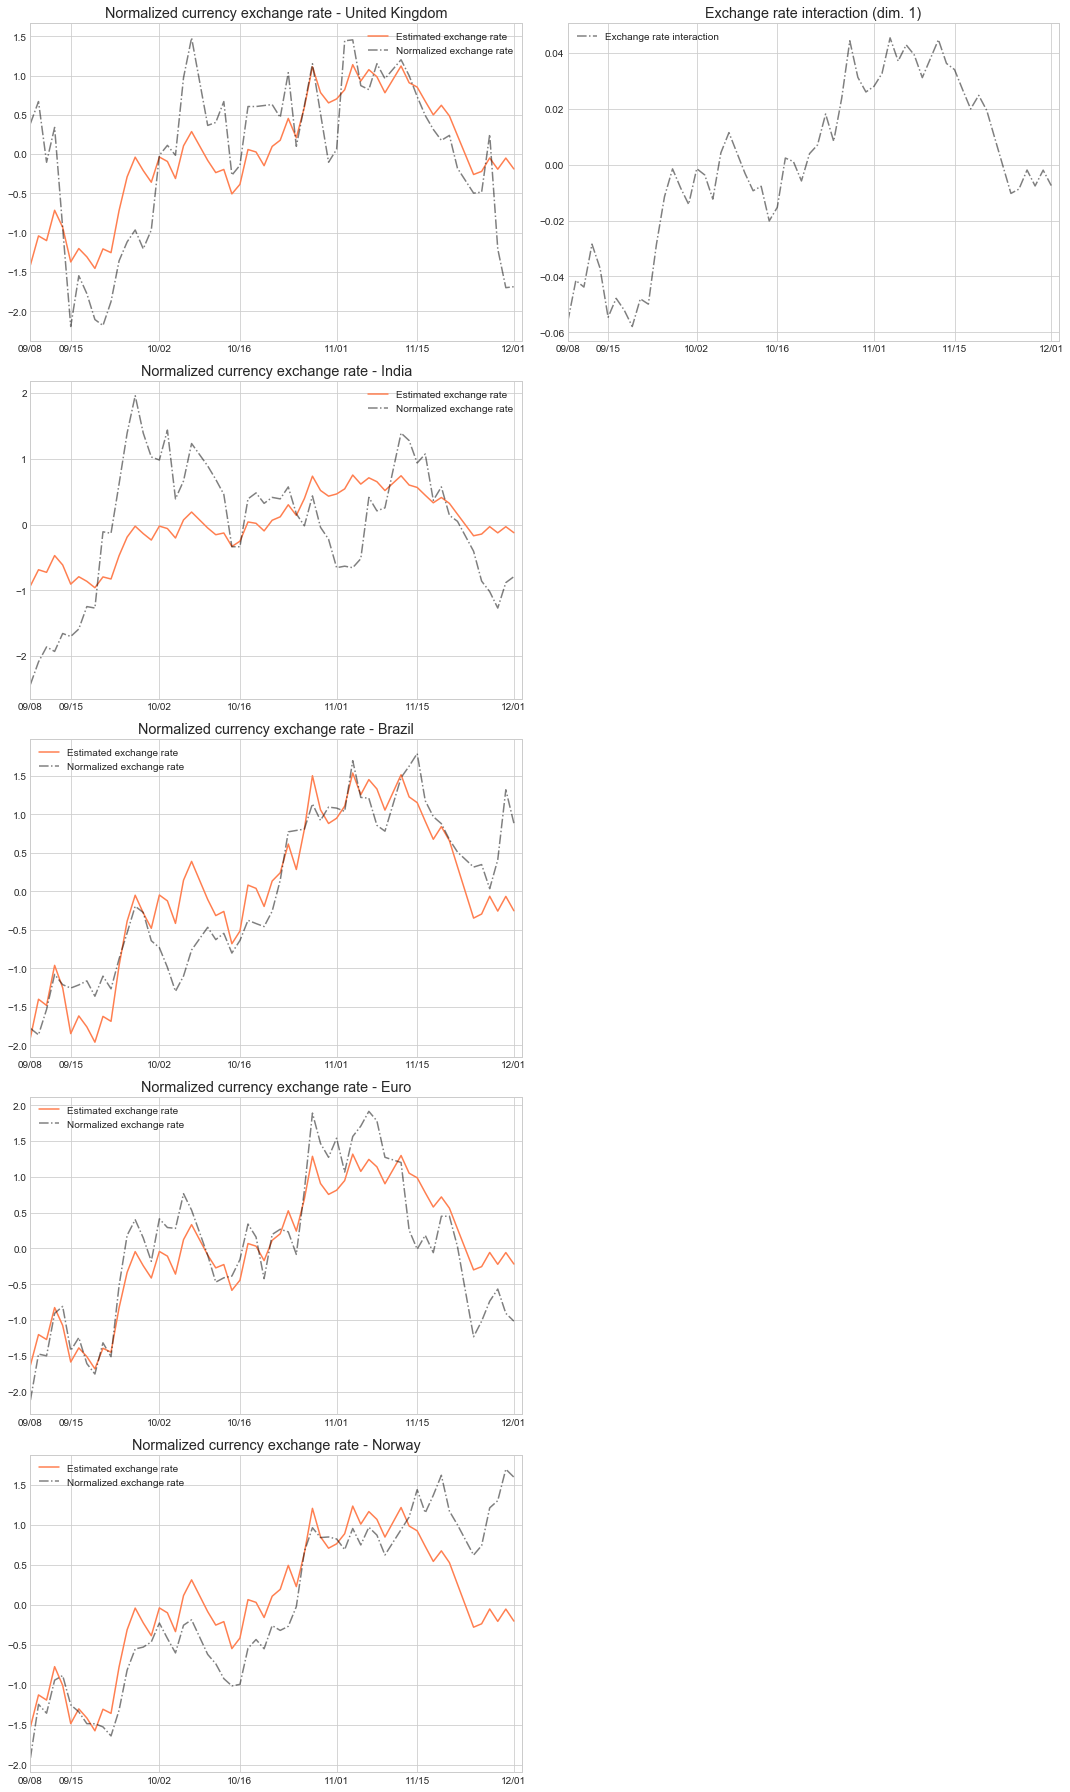

In [13]:
Y = country_rates.astype("f8")
Y = Y[:, -61:]
Y_dates = valid_dates[-61: ]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 1
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=100,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e9,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

In [14]:
Y_dates[29]
#https://www.dailymail.co.uk/home/sitemaparchive/day_20171019.html
#The Latest: Merkel says May's Brexit effort still not enough
#https://www.dailymail.co.uk/home/sitemaparchive/day_20171018.html
#US STOCKS-Dow ends above 23,000 for first time; IBM jumps

'2017-10-19'

4498 : 4618 (5, 4935) (4935,)

* Log-likelihood: 0
* Low variance Q: 10
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0.01
* MSE: 0.36
* Roughness X: 0.76
* Roughness Y: 70

* Log-likelihood: 0
* Low variance Q: 1.3e+02
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0.01
* MSE: 0.36
* Roughness X: 0.75
* Roughness Y: 69

* Log-likelihood: 0
* Low variance Q: 6.3e+02
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 6.8
* MSE: 0.37
* Roughness X: 53
* Roughness Y: 2.6e+04

* Log-likelihood: 0
* Low variance Q: 1.4e+03
* Low variance R: 0.56
* Low variance P0: 0
* Low std/mean ratio: 1
* Inestable system: 72
* MSE: 0.37
* Roughness X: 0.89
* Roughness Y: 90


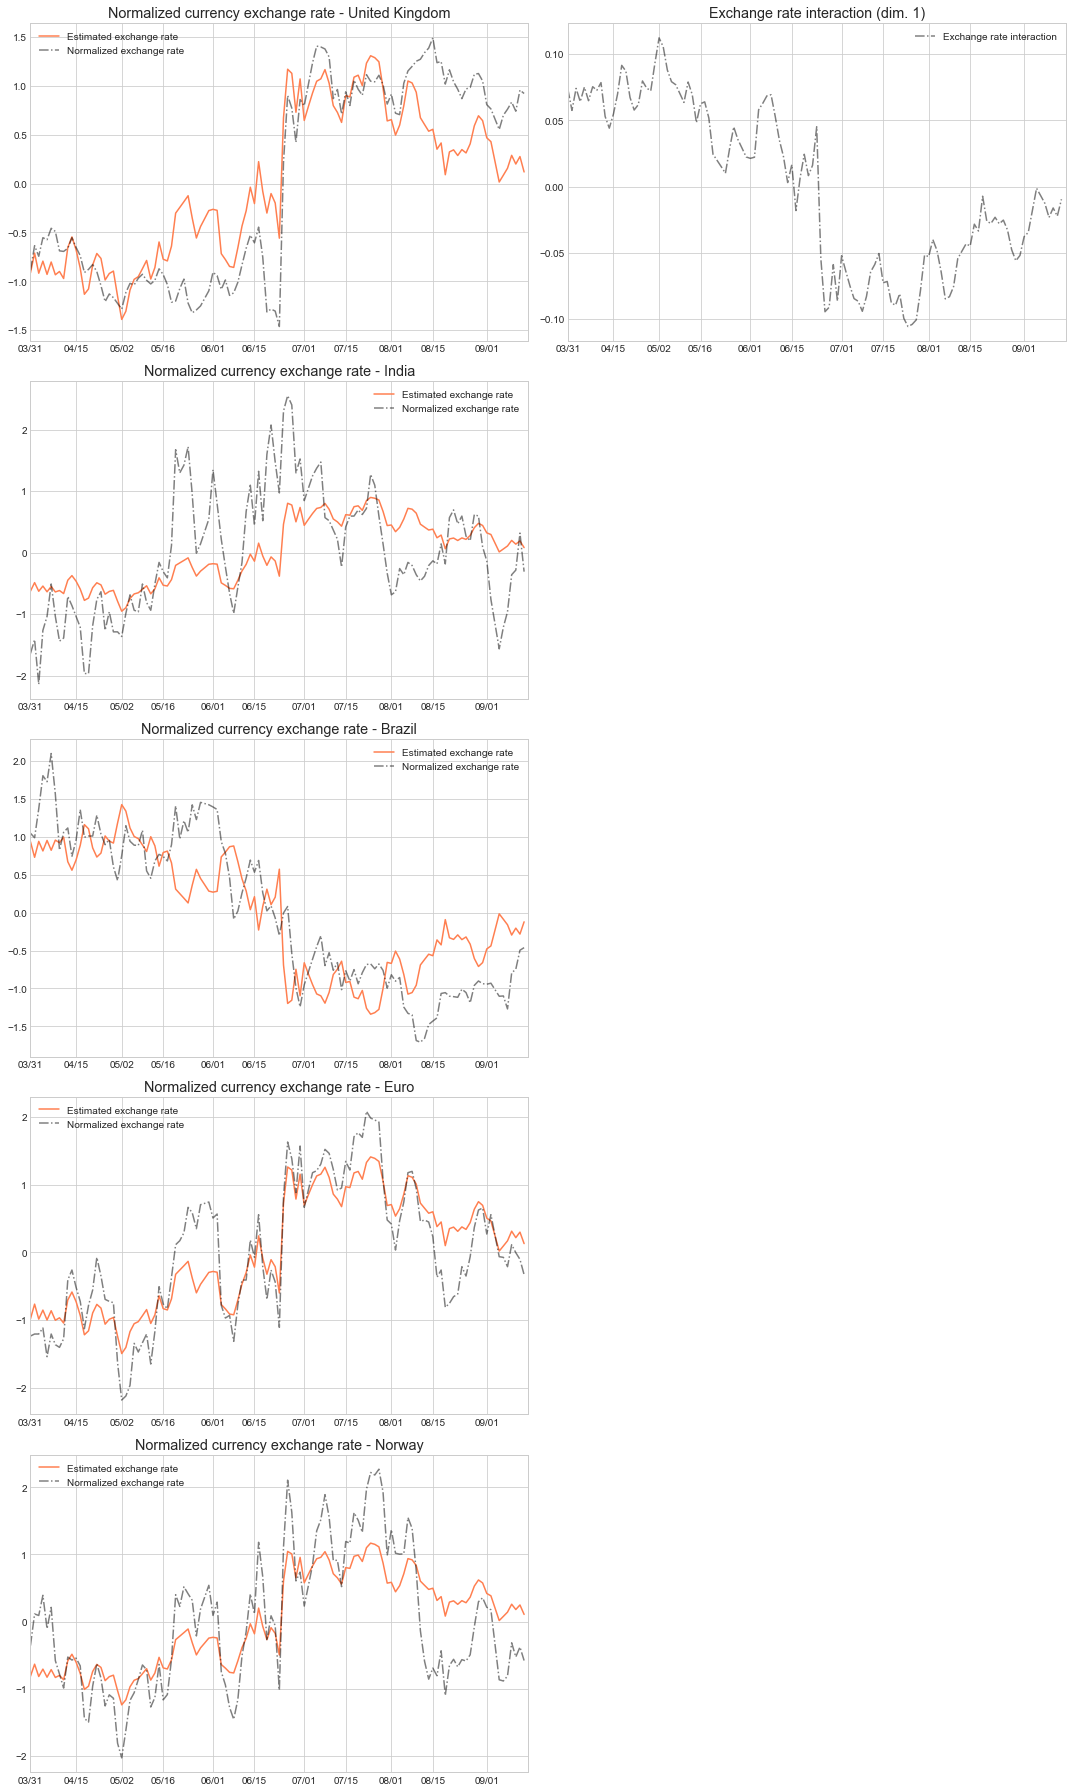

In [15]:
trump_election_day = '2016-06-23'#'2016-09-08'
index_trump_election_day = np.where(valid_dates == trump_election_day)[0][0]
days_before, days_after = 60, 60
Y = country_rates.astype("f8")
print(index_trump_election_day - days_before, ":", index_trump_election_day + days_after, Y.shape, valid_dates.shape)
# Y = country_rates.astype("f8")
Y = Y[:, index_trump_election_day - days_before: index_trump_election_day + days_after]
Y_dates = valid_dates[index_trump_election_day - days_before: index_trump_election_day + days_after]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 1
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=110,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e15,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

4498 : 4618 (5, 4935) (4935,)

* Log-likelihood: 0
* Low variance Q: 10
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 14
* MSE: 0.36
* Roughness X: 0.76
* Roughness Y: 70

* Log-likelihood: 0
* Low variance Q: 7.8
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 14
* MSE: 0.36
* Roughness X: 0.75
* Roughness Y: 68

* Log-likelihood: 0
* Low variance Q: 5.6e+02
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 1.1e+02
* MSE: 0.48
* Roughness X: 5.3e+03
* Roughness Y: 1.9e+06

* Log-likelihood: 0
* Low variance Q: 20
* Low variance R: 1
* Low variance P0: 0
* Low std/mean ratio: 0.69
* Inestable system: 1.5e+02
* MSE: 0.36
* Roughness X: 0.59
* Roughness Y: 61


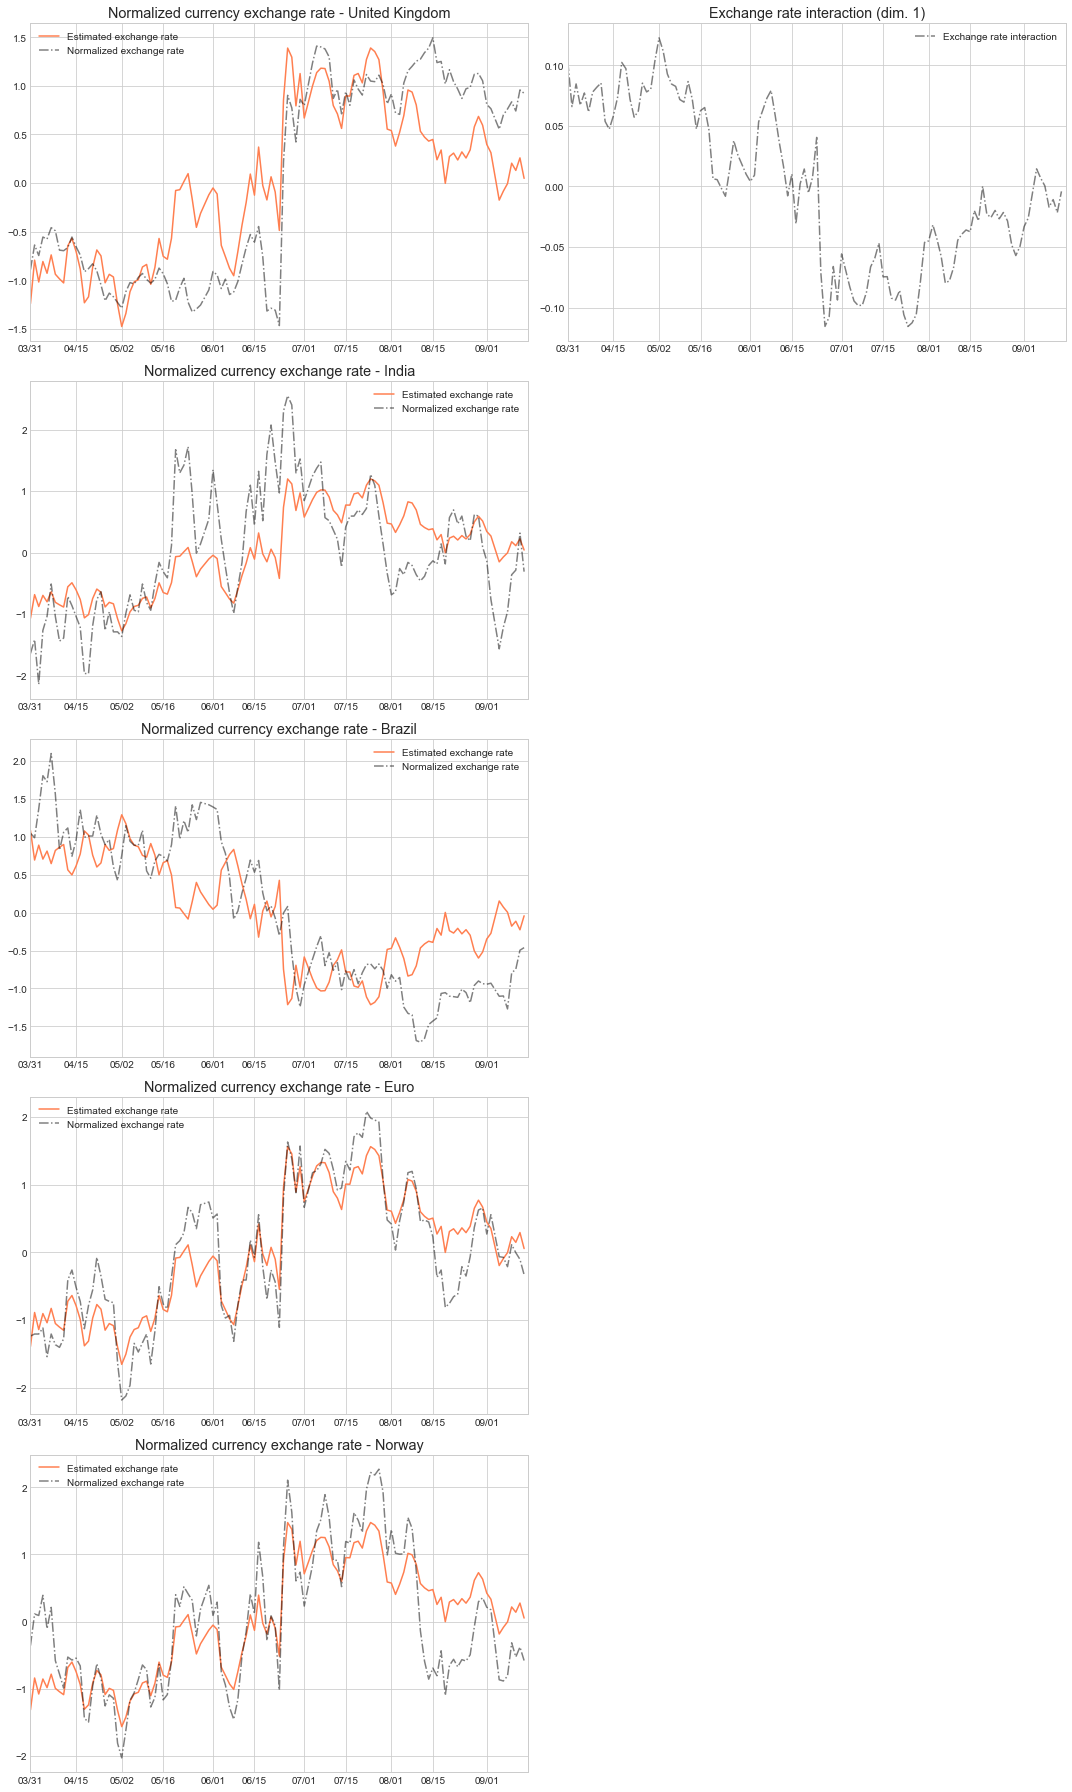

In [16]:
trump_election_day = '2016-06-23'
index_trump_election_day = np.where(valid_dates == trump_election_day)[0][0]
days_before, days_after = 60, 60
Y = country_rates.astype("f8")
print(index_trump_election_day - days_before, ":", index_trump_election_day + days_after, Y.shape, valid_dates.shape)
# Y = country_rates.astype("f8")
Y = Y[:, index_trump_election_day - days_before: index_trump_election_day + days_after]
Y_dates = valid_dates[index_trump_election_day - days_before: index_trump_election_day + days_after]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 1
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=100,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e15,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "EM+PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

4498 : 4618 (5, 4935) (4935,)

* Log-likelihood: 0
* Low variance Q: 10
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0.52
* MSE: 0.36
* Roughness X: 0.8
* Roughness Y: 82

* Log-likelihood: 0
* Low variance Q: 80
* Low variance R: 0.01
* Low variance P0: 0
* Low std/mean ratio: 0.01
* Inestable system: 0.52
* MSE: 0.36
* Roughness X: 0.81
* Roughness Y: 82

* Log-likelihood: 0
* Low variance Q: 6.5e+02
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 1.4e+04
* MSE: 0.52
* Roughness X: 23
* Roughness Y: 6.3e+02

* Log-likelihood: 0
* Low variance Q: 52
* Low variance R: 1
* Low variance P0: 0.01
* Low std/mean ratio: 1
* Inestable system: 5.9
* MSE: 0.37
* Roughness X: 0.52
* Roughness Y: 46


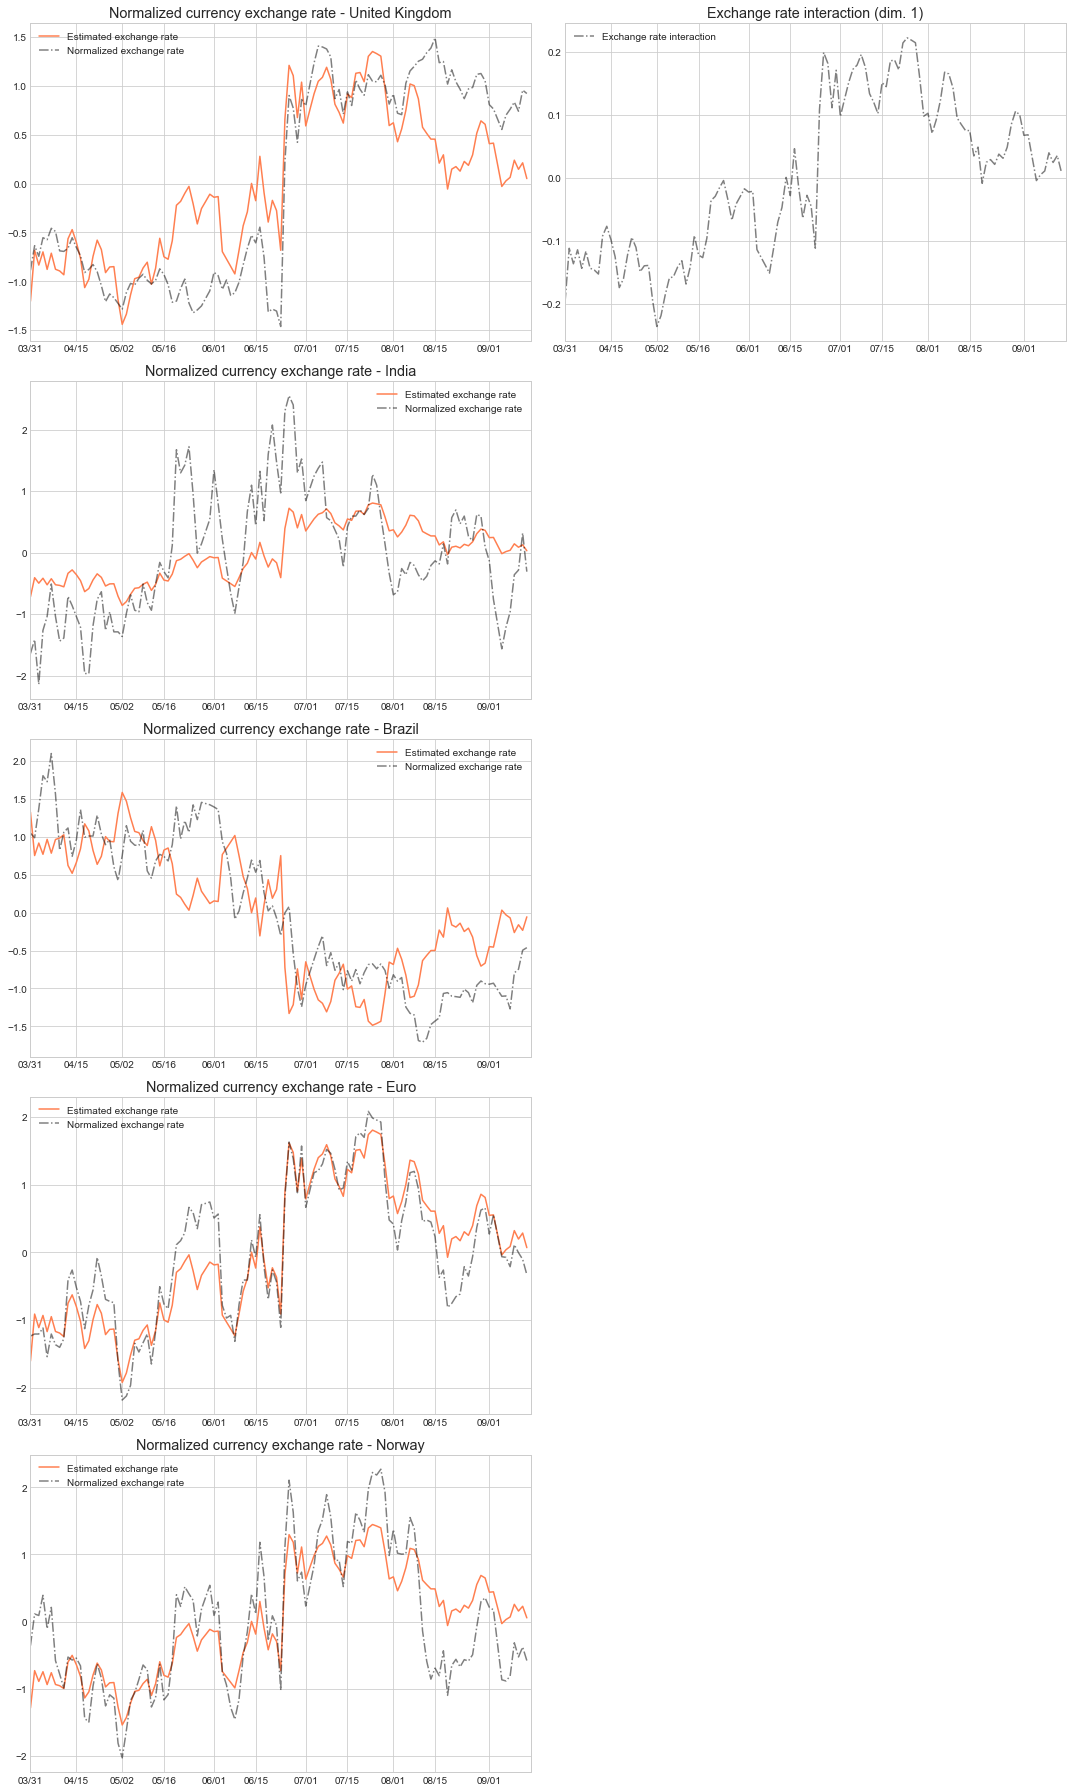

In [19]:
trump_election_day = '2016-06-23'
index_trump_election_day = np.where(valid_dates == trump_election_day)[0][0]
days_before, days_after = 60, 60
Y = country_rates.astype("f8")
print(index_trump_election_day - days_before, ":", index_trump_election_day + days_after, Y.shape, valid_dates.shape)
# Y = country_rates.astype("f8")
Y = Y[:, index_trump_election_day - days_before: index_trump_election_day + days_after]
Y_dates = valid_dates[index_trump_election_day - days_before: index_trump_election_day + days_after]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 1
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=110,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e15,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "LSE+PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))

4498 : 4618 (5, 4935) (4935,)

* Log-likelihood: 0
* Low variance Q: 7.5
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 1.5e+02
* MSE: 0.15
* Roughness X: 7
* Roughness Y: 1.3e+03

* Log-likelihood: 0
* Low variance Q: 5.1
* Low variance R: 0
* Low variance P0: 0
* Low std/mean ratio: 0
* Inestable system: 1.5e+02
* MSE: 0.15
* Roughness X: 6.6
* Roughness Y: 1.3e+03

* Log-likelihood: 0
* Low variance Q: 7.3e+02
* Low variance R: 0.01
* Low variance P0: 0.03
* Low std/mean ratio: 0.01
* Inestable system: 3.1e+02
* MSE: 0.6
* Roughness X: 2.5e+02
* Roughness Y: 1.2e+05

* Log-likelihood: 0
* Low variance Q: 1.7e+02
* Low variance R: 0.65
* Low variance P0: 0.01
* Low std/mean ratio: 0.16
* Inestable system: 29
* MSE: 0.15
* Roughness X: 14
* Roughness Y: 2.7e+03


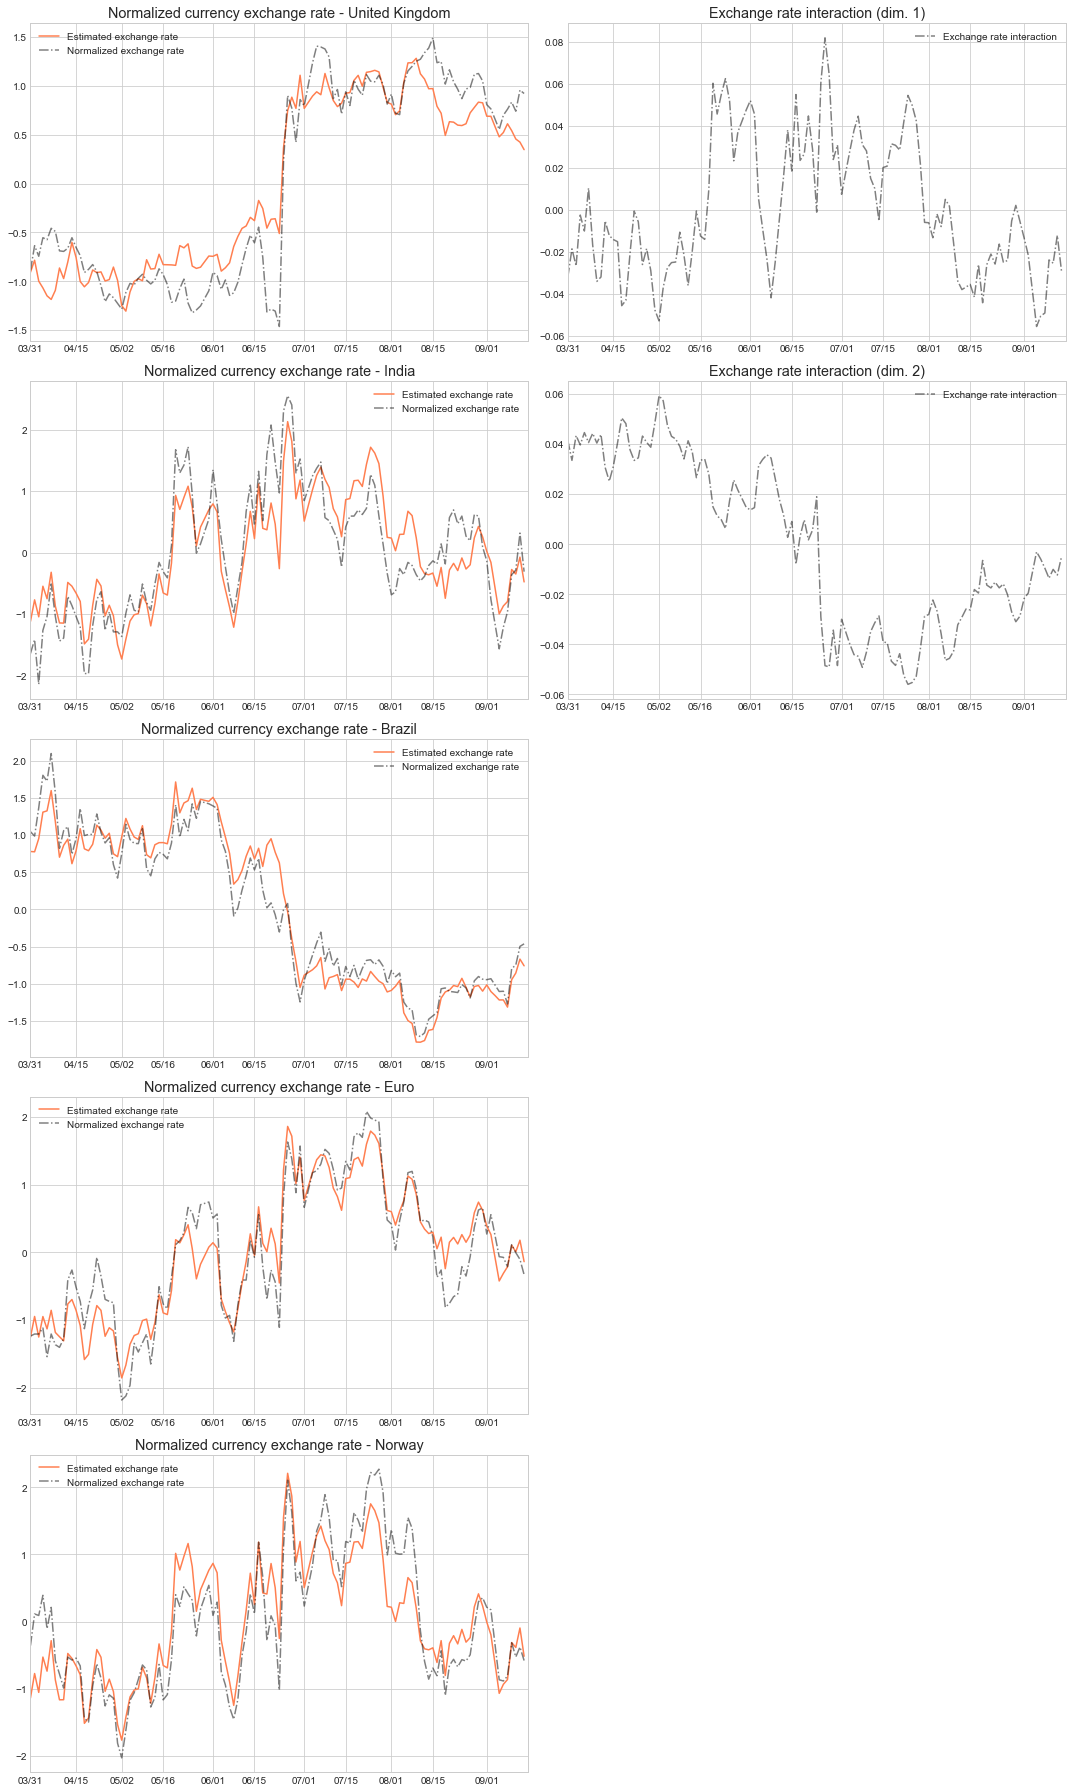

In [22]:
trump_election_day = '2016-06-23'#'2016-09-08'
index_trump_election_day = np.where(valid_dates == trump_election_day)[0][0]
days_before, days_after = 60, 60
Y = country_rates.astype("f8")
print(index_trump_election_day - days_before, ":", index_trump_election_day + days_after, Y.shape, valid_dates.shape)
# Y = country_rates.astype("f8")
Y = Y[:, index_trump_election_day - days_before: index_trump_election_day + days_after]
Y_dates = valid_dates[index_trump_election_day - days_before: index_trump_election_day + days_after]
#Y = (Y.T - Y[:, 0]).T
Y = ((Y.T - Y.mean(axis=1)) / Y.std(axis=1)).T
#Y = Y[:, -30:]

lat_dim = 2
estimation_params = dict(
        min_iterations=3,
        max_iterations=50,

        min_improvement=0.01,
        sample_size=10000,
        population_size=100,
        penalty_low_variance_Q=0,#0.5,
        penalty_low_variance_R=0,#0.5,
        penalty_low_variance_P0=0,#0.5,
        penalty_low_std_mean_ratio=0,#0.5,
        penalty_inestable_system=0,#10.0,
        penalty_mse=1e15,#100,#1e-1,
        penalty_roughness_X=0,#0.5,
        penalty_roughness_Y=0,#0.5,
        max_length_loglikelihood=1000,
        return_details=True,
        random_spread=10,
)
method = "PSO"
params1 = resdict_fromdata(ssm.estimate(
        method, "F H", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=None, H=None, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params1.show_performance(Y)
params2 = resdict_fromdata(ssm.estimate(
        method, "X0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params1.F, H=params1.H, 
        Q=None, R=None, 
        X0=None, P0=None,
        **estimation_params
))
print(); params2.show_performance(Y)
params3 = resdict_fromdata(ssm.estimate(
        method, "Q R P0", Y,
        Y.shape[0], 6, Y.shape[1],
        F=params2.F, H=params2.F, 
        Q=params2.Q, R=params2.R, 
        X0=None, P0=None,
        **estimation_params
))
print(); params3.show_performance(Y)
params4 = resdict_fromdata(ssm.estimate(
        method, "H F Q R X0 P0", Y,
        Y.shape[0], lat_dim, Y.shape[1],
        F=params3.F, H=params3.F, 
        Q=params3.Q, R=params3.R, 
        X0=params3.X0, P0=params3.P0,
        **estimation_params
))
print(); params4.show_performance(Y)
plot_fitted_data(countries, params4.Xs, params4.Ys, Y, dates=ticks_from_first_week_day(Y_dates))